In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Import the pipelines from the regression_pipelines module
from Regression_Model_Pipeline import create_pipelines, tune_models, evaluate_models, create_and_fit_model
from Regression_Model_Pipeline import create_categorical_preprocessor, create_numerical_preprocessor
import warnings                               #ignore warnings
warnings. filterwarnings("ignore")
import seaborn as sns                         #data visualization
import matplotlib.pyplot as plt               #data visualization
from sklearn.model_selection import GridSearchCV

In [19]:
#Load your dataset
# data = pd.read_csv("https://static.bc-edx.com/ai/ail-v-1-0/m12/lesson_1/datasets/car-data-encoded.csv")
data = pd.read_csv('garments_worker_productivity.csv')
data.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [20]:
data_copy = data.copy()

# Convert date strings to datetime format if applicable
date_columns = data_copy.select_dtypes(include=['object']).columns.tolist()
for col in date_columns:
    try:
        data_copy[col] = pd.to_datetime(data_copy[col])
    except (ValueError, TypeError):
        # If conversion fails, you can choose to drop the column or handle it differently
        print(f"Column '{col}' could not be converted to datetime.")

# Calculate the mean of the 'wip' column
mean_wip = data_copy['wip'].mean()

# Fill missing values in 'wip' with the mean
data_copy['wip'].fillna(value=mean_wip, inplace=True)

Column 'quarter' could not be converted to datetime.
Column 'department' could not be converted to datetime.
Column 'day' could not be converted to datetime.


In [21]:
print(data_copy.isnull().sum())

date                     0
quarter                  0
department               0
day                      0
team                     0
targeted_productivity    0
smv                      0
wip                      0
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
no_of_workers            0
actual_productivity      0
dtype: int64


In [22]:
# Please enter the Target name that you wish to use
target = 'actual_productivity'

# Step 2: Define your features (X) and target (y)
X = data_copy.drop(target, axis=1)  # Replace 'target_column' with your actual target column name
y = data_copy[target].values.reshape(-1,1)  # Your target variable

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## This section determines which columns are categorical or numerical

In [23]:
# Drop the target column from the copy
data_copy = data_copy.drop(columns=[target]) 

# Determine categorical and numerical features
categorical_features = data_copy.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = data_copy.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create the preprocessor for just the numerical columns
num_preprocessor = create_numerical_preprocessor(numerical_features)

# Create the preprocessor for just the categorical columns
cat_preprocessor = create_categorical_preprocessor(categorical_features)

# Print the identified features (optional)
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: ['quarter', 'department', 'day']
Numerical Features: ['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']


## Correlation Analysis

In [24]:
from scipy.sparse import csr_matrix

numerical_data = num_preprocessor.fit_transform(data_copy[numerical_features])
categorical_data = cat_preprocessor.fit_transform(data_copy[categorical_features])

# Check the shapes and types of the outputs
print("Numerical Data Shape:", numerical_data.shape)  # Should be (1197, 10)
print("Categorical Data Shape:", categorical_data.shape)  # Should be (1197, 14)
print("Type of Categorical Data:", type(categorical_data))  # Should be a DataFrame or array

# Convert the NumPy arrays back to DataFrames
numerical_df = pd.DataFrame(numerical_data, columns=numerical_features)

# Check if categorical_data is a sparse matrix and convert it to dense if necessary
if isinstance(categorical_data, csr_matrix):
    categorical_data = categorical_data.toarray()  # Convert sparse to dense

# Now create the DataFrame for categorical data
categorical_df = pd.DataFrame(categorical_data, columns=cat_preprocessor.get_feature_names_out(categorical_features))

# Print the shapes of the DataFrames to check for consistency
print("Numerical DataFrame Shape:", numerical_df.shape)  # Should be (1197, 10)
print("Categorical DataFrame Shape:", categorical_df.shape)  # Should be (1197, 14)

# Combine the processed numerical and categorical DataFrames
processed_data = pd.concat([numerical_df, categorical_df], axis=1)

# Now you can perform correlation analysis
correlation_matrix = processed_data.corr()  # This will work for numerical features
print(correlation_matrix)

Numerical Data Shape: (1197, 10)
Categorical Data Shape: (1197, 14)
Type of Categorical Data: <class 'scipy.sparse._csr.csr_matrix'>
Numerical DataFrame Shape: (1197, 10)
Categorical DataFrame Shape: (1197, 14)
                           team  targeted_productivity       smv  \
team                   1.000000               0.030274 -0.110011   
targeted_productivity  0.030274               1.000000 -0.069489   
smv                   -0.110011              -0.069489  1.000000   
wip                   -0.025384               0.049114 -0.018322   
over_time             -0.096737              -0.088557  0.674887   
incentive             -0.007674               0.032768  0.032629   
idle_time              0.003796              -0.056181  0.056863   
idle_men               0.026974              -0.053818  0.105901   
no_of_style_change    -0.011194              -0.209294  0.315388   
no_of_workers         -0.075113              -0.084288  0.912176   
quarter_Quarter1      -0.018775          

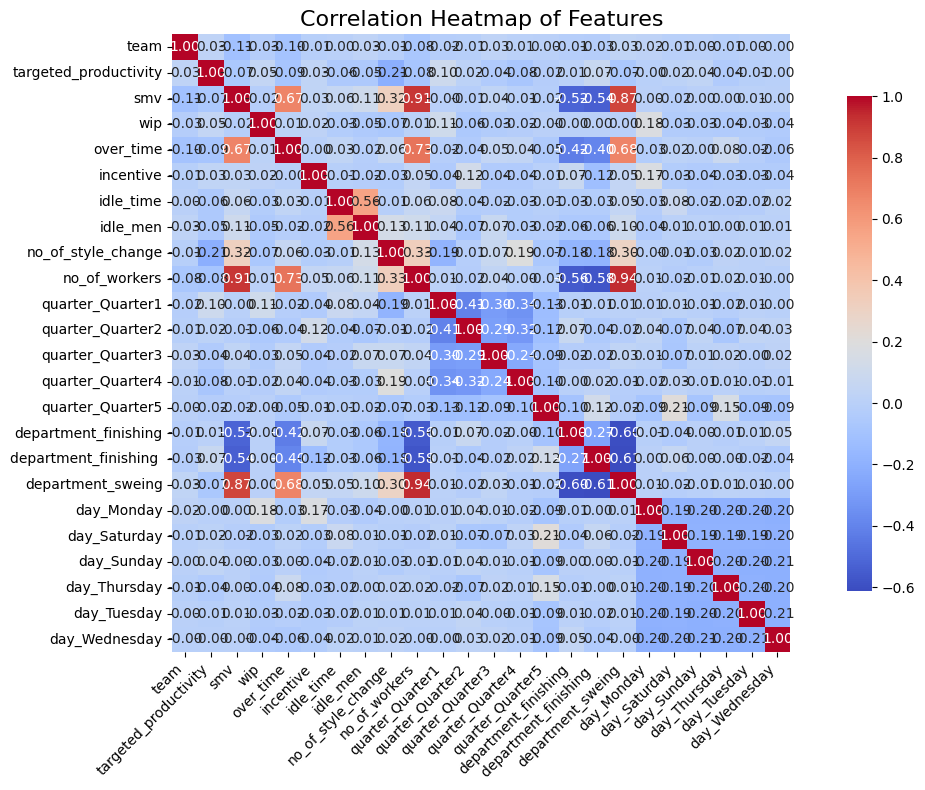

In [25]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))  # You can adjust the size as needed

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Add titles and labels
plt.title('Correlation Heatmap of Features', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()

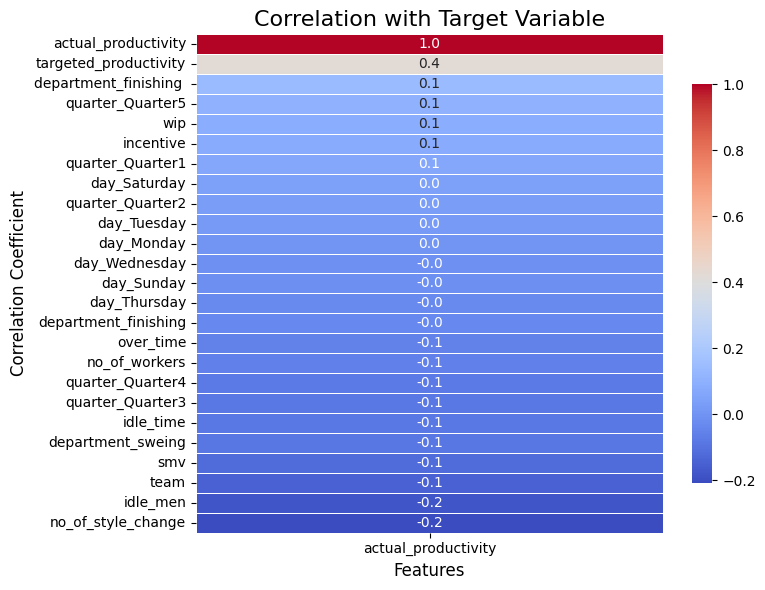

In [32]:
# Assuming 'y' is your target variable as a 2D array, flatten it to 1D
y_flat = y.ravel()  # or use y.flatten() if y is a NumPy array

# Define the target column name
target = 'actual_productivity'  # Replace with your actual target column name

# Create a Series from the flattened target variable
target_series = pd.Series(y_flat, name=target)

# Combine features and target into a new DataFrame
processed_data_with_target = pd.concat([processed_data, target_series], axis=1)

# Calculate the correlation matrix including the target variable
correlation_matrix_with_target = processed_data_with_target.corr()

# Focus on correlations with the target variable and sort them
target_correlation = correlation_matrix_with_target[[target]].sort_values(by=target, ascending=False)

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))  # Adjust size for readability

# Create a heatmap with only the target correlations
sns.heatmap(target_correlation, annot=True, fmt=".1f", cmap='coolwarm', cbar_kws={"shrink": .8}, linewidths=0.5)

# Add titles and labels
plt.title('Correlation with Target Variable', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
X = pd.DataFrame(processed_data)  # Replace with your processed dataset

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

## Fitting and Transforming the Data

In [7]:
# Ensure that X_train and X_test only contain numerical features
# Remove any columns that are not numeric
X_train = X_train.select_dtypes(include=['int64', 'float64'])
X_test = X_test.select_dtypes(include=['int64', 'float64'])

# Check for any non-numeric columns before fitting
print("X_train columns:", X_train.columns)
print("X_test columns:", X_test.columns)

X_train columns: Index(['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers'],
      dtype='object')
X_test columns: Index(['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers'],
      dtype='object')


In [8]:
# Fit and transform the training data
X_train_processed = num_preprocessor.fit_transform(X_train)

# Transform the testing data
X_test_processed = num_preprocessor.transform(X_test)

# This section fits each of the regression models

In [9]:
# Dictionary of regression models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest Regression': RandomForestRegressor(),
    'Support Vector Regression': SVR(),
    'Elastic Net': ElasticNet(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Gradient Boost Regression': GradientBoostingRegressor(),
    'KNeighbors Regression': KNeighborsRegressor()
}

# Create pipelines using the preprocessor and models
pipelines = create_pipelines(num_preprocessor, models)

In [10]:
metrics_df = evaluate_models(pipelines, X_train_processed, y_train, X_test_processed, y_test)

X_train shape: (897, 10)
y_train shape: (897, 1)
X_test shape: (300, 10)
y_test shape: (300, 1)
                           Training Score  Testing Score  Mean Absolute Error  Mean Squared Error  R² Score
Lasso Regression                 0.000000      -0.000685             0.128256            0.028178 -0.000685
Elastic Net                      0.000000      -0.000685             0.128256            0.028178 -0.000685
Linear Regression                0.306007       0.188046             0.109552            0.022864  0.188046
Ridge Regression                 0.305997       0.188579             0.109464            0.022849  0.188579
Support Vector Regression        0.496357       0.317175             0.095912            0.019228  0.317175
KNeighbors Regression            0.574632       0.388269             0.086326            0.017226  0.388269
Gradient Boost Regression        0.663522       0.434893             0.081950            0.015913  0.434893
Decision Tree Regression         0.88589

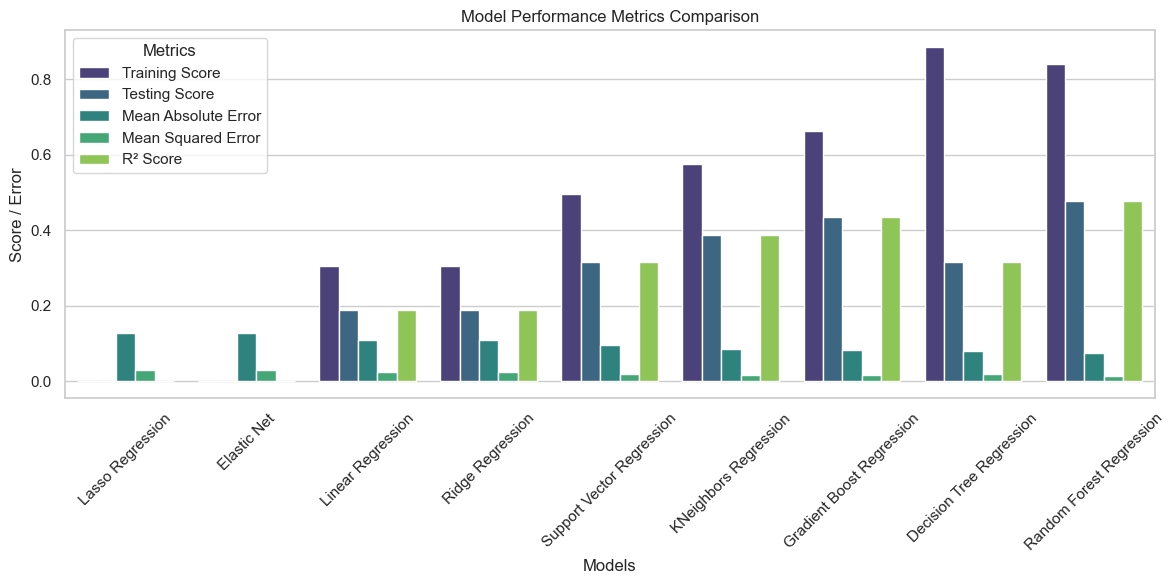

In [11]:
# Convert the dictionary to a DataFrame
# metrics_df = pd.DataFrame(performance_metrics).T

# Reset the index to have model names as a column
metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={'index': 'Model'}, inplace=True)

# Melt the DataFrame for better plotting
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Set the plot style
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_melted, palette='viridis')

# Customize the plot
plt.title('Model Performance Metrics Comparison')
plt.ylabel('Score / Error')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.legend(title='Metrics')

# Show the plot
plt.tight_layout()
plt.show()

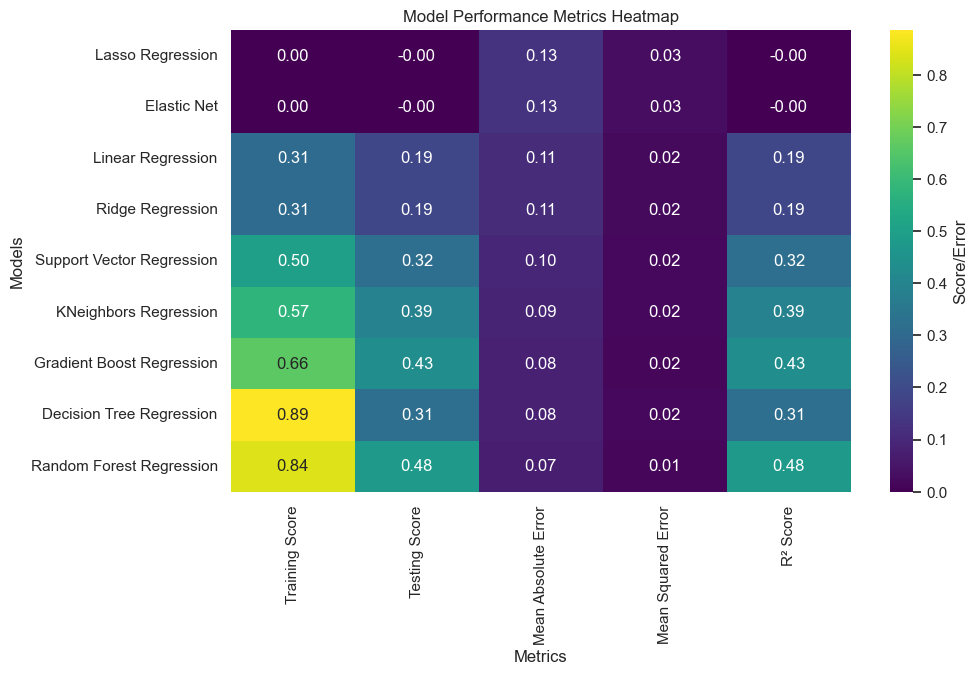

                           Training Score  Testing Score  Mean Absolute Error  \
Model                                                                           
Lasso Regression                 0.000000      -0.000685             0.128256   
Elastic Net                      0.000000      -0.000685             0.128256   
Linear Regression                0.306007       0.188046             0.109552   
Ridge Regression                 0.305997       0.188579             0.109464   
Support Vector Regression        0.496357       0.317175             0.095912   
KNeighbors Regression            0.574632       0.388269             0.086326   
Gradient Boost Regression        0.663522       0.434893             0.081950   
Decision Tree Regression         0.885893       0.314978             0.079652   
Random Forest Regression         0.840723       0.476603             0.074872   

                           Mean Squared Error  R² Score  
Model                                             

In [12]:
# Reset the index and drop the old index
metrics_df.reset_index(drop=True, inplace=True)

# Rename the first column to 'Model' if it's not already named
metrics_df.rename(columns={'index': 'Model'}, inplace=True)

# Set 'Model' as the index
metrics_df.set_index('Model', inplace=True)

# Create a heatmap with only numeric data
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df.select_dtypes(include=[np.number]), annot=True, cmap='viridis', fmt='.2f', cbar_kws={'label': 'Score/Error'})

# Customize the plot
plt.title('Model Performance Metrics Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.show()

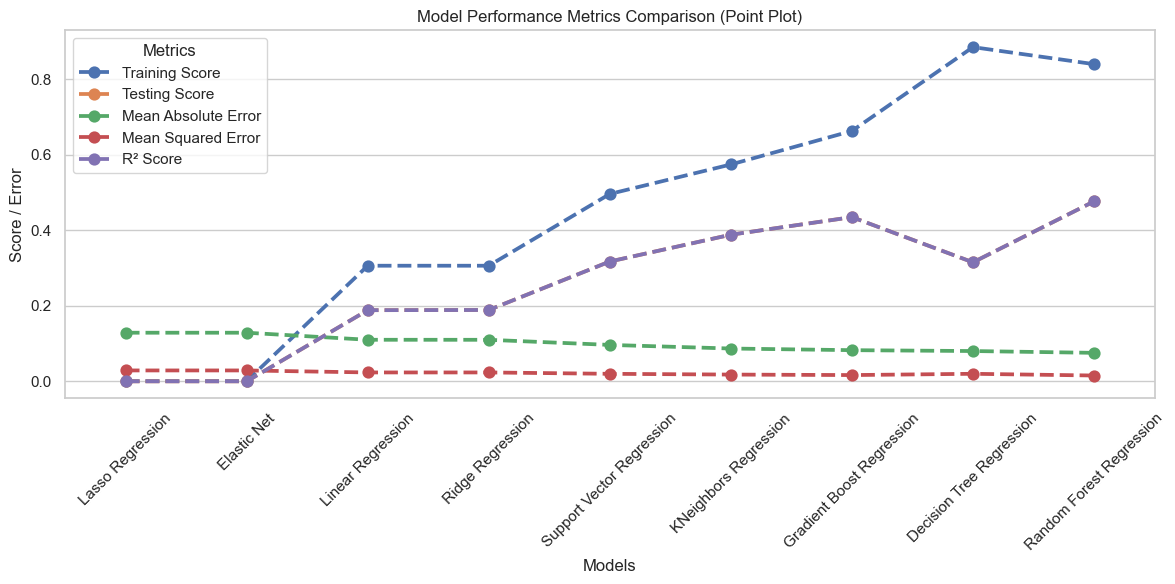

In [14]:
# Reset the index to bring 'Model' back as a column
metrics_df_reset = metrics_df.reset_index()

# Melt the DataFrame for better plotting
metrics_melted = metrics_df_reset.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create a point plot
plt.figure(figsize=(12, 6))
sns.pointplot(x='Model', y='Score', hue='Metric', data=metrics_melted, markers='o', linestyles='--')

# Customize the plot
plt.title('Model Performance Metrics Comparison (Point Plot)')
plt.ylabel('Score / Error')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.legend(title='Metrics')

# Show the plot
plt.tight_layout()
plt.show()

## This Section is Hyper Parameter Tuning for Models to Try to Improve Model Score

In [15]:
# Define parameter grids for each model
param_grids = {
    'Linear Regression': {},
    'Lasso Regression': {
        'regressor__alpha': [0.01, 0.1, 1.0, 10.0]
    },
    'Ridge Regression': {
        'regressor__alpha': [0.01, 0.1, 1.0, 10.0]
    },
    'Random Forest Regression': {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf': [1, 2],
        'regressor__max_features': ['auto', 'sqrt']
    },
    'Support Vector Regression': {
        'regressor__C': [0.1, 1, 10],
        'regressor__epsilon': [0.1, 0.2, 0.5]
    },
    'Elastic Net': {
        'regressor__alpha': [0.01, 0.1, 1.0],
        'regressor__l1_ratio': [0.1, 0.5, 0.9]
    },
    'Decision Tree Regression': {
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf': [1, 2]
    },
    'Gradient Boost Regression': {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 5, 7]
    },
    'KNeighbors Regression': {
        'regressor__n_neighbors': [3, 5, 10],
        'regressor__weights': ['uniform', 'distance']
    }
}

tuning_results = tune_models(pipelines, param_grids, X_train, y_train)

# Print tuning results
print("\nTuning Results:")
print("=" * 50)  # Separator line
for model_name, result in tuning_results.items():
    best_params = result['best_params']
    best_score = result['best_score']
    
    # Format the parameters for better readability
    params_str = ', '.join([f"{key}: {value}" for key, value in best_params.items()])
    
    print(f"Model: {model_name}")
    print(f"  Best Parameters: {params_str}")
    print(f"  Best Score (Neg MSE): {best_score:.4f}")
    print("-" * 50)  # Separator line

Tuning Linear Regression...
Tuning Lasso Regression...
Tuning Ridge Regression...
Tuning Random Forest Regression...
Tuning Support Vector Regression...
Tuning Elastic Net...
Tuning Decision Tree Regression...
Tuning Gradient Boost Regression...
Tuning KNeighbors Regression...

Tuning Results:
Model: Linear Regression
  Best Parameters: 
  Best Score (Neg MSE): -0.0242
--------------------------------------------------
Model: Lasso Regression
  Best Parameters: regressor__alpha: 0.01
  Best Score (Neg MSE): -0.0236
--------------------------------------------------
Model: Ridge Regression
  Best Parameters: regressor__alpha: 10.0
  Best Score (Neg MSE): -0.0222
--------------------------------------------------
Model: Random Forest Regression
  Best Parameters: regressor__max_depth: 20, regressor__max_features: sqrt, regressor__min_samples_leaf: 2, regressor__min_samples_split: 2, regressor__n_estimators: 200
  Best Score (Neg MSE): -0.0152
---------------------------------------------

In [16]:
fitted_models = {}

for model_name, result in tuning_results.items():
    best_params = result['best_params']
    fitted_model = create_and_fit_model(model_name, best_params, X_train, y_train, pipelines)
    fitted_models[model_name] = fitted_model  # Store the fitted model

In [37]:
fitted_metrics_df = evaluate_models(fitted_models, X_train, y_train, X_test, y_test)

X_train shape: (897, 10)
y_train shape: (897, 1)
X_test shape: (300, 10)
y_test shape: (300, 1)
                           Training Score  Testing Score  Mean Absolute Error  Mean Squared Error  R² Score
Linear Regression                0.306007       0.188046             0.109552            0.022864  0.188046
Lasso Regression                 0.254333       0.170077             0.109296            0.023370  0.170077
Ridge Regression                 0.305275       0.191695             0.108875            0.022761  0.191695
Elastic Net                      0.303058       0.193400             0.108250            0.022713  0.193400
Support Vector Regression        0.496357       0.317175             0.095912            0.019228  0.317175
KNeighbors Regression            0.514701       0.323550             0.089639            0.019048  0.323550
Decision Tree Regression         0.748720       0.345696             0.082957            0.018425  0.345696
Gradient Boost Regression        0.73741

In [38]:
# Combine original and fitted metrics into a single DataFrame for comparison
comparison_df = pd.concat([metrics_df, fitted_metrics_df], axis=1)

# Create a multi-level column index
comparison_df.columns = pd.MultiIndex.from_tuples([
    ('Original', 'Training Score'),
    ('Original', 'Testing Score'),
    ('Original', 'MAE'),
    ('Original', 'MSE'),
    ('Original', 'R² Score'),
    ('Fitted', 'Training Score'),
    ('Fitted', 'Testing Score'),
    ('Fitted', 'MAE'),
    ('Fitted', 'MSE'),
    ('Fitted', 'R² Score'),
])

# Display the comparison DataFrame
print(comparison_df.to_string(index=True))

                                Original                                                     Fitted                                            
                          Training Score Testing Score       MAE       MSE  R² Score Training Score Testing Score       MAE       MSE  R² Score
Lasso Regression                0.000000     -0.000685  0.128256  0.028178 -0.000685       0.254333      0.170077  0.109296  0.023370  0.170077
Elastic Net                     0.000000     -0.000685  0.128256  0.028178 -0.000685       0.303058      0.193400  0.108250  0.022713  0.193400
Linear Regression               0.306007      0.188046  0.109552  0.022864  0.188046       0.306007      0.188046  0.109552  0.022864  0.188046
Ridge Regression                0.305997      0.188579  0.109464  0.022849  0.188579       0.305275      0.191695  0.108875  0.022761  0.191695
Support Vector Regression       0.496357      0.317175  0.095912  0.019228  0.317175       0.496357      0.317175  0.095912  0.019228  0

#### The table is sorted descending based on the MAE which is often preferred when you want a straightforward interpretation of average error. 
#### A lower MAE value indicates better model performance, as it means that the model's predictions are closer to the actual values on average. This is generally desirable in predictive modeling. 
#### A higher MAE value suggests that the model's predictions are further away from the actual values, indicating poorer performance.

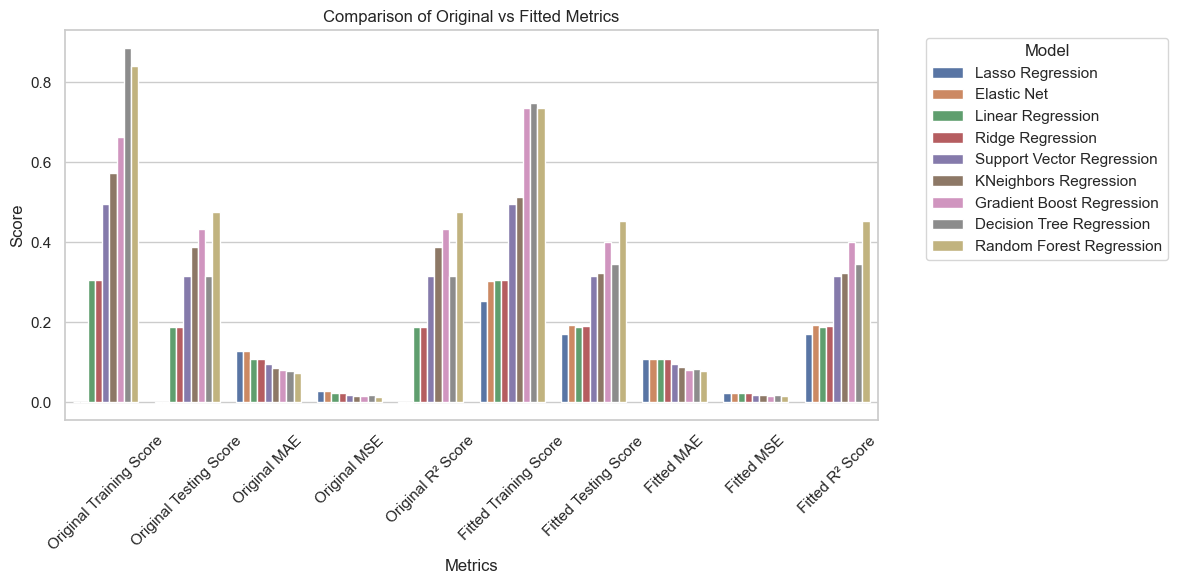

In [44]:
# Assuming comparison_df is your DataFrame with multi-level columns
# Reset the index to have a flat DataFrame for plotting
comparison_flat = comparison_df.reset_index()

# Flatten the MultiIndex columns
comparison_flat.columns = ['Model'] + [f'{level_0} {level_1}' for level_0, level_1 in comparison_flat.columns[1:]]

# Melt the DataFrame to long format for Seaborn
comparison_melted = comparison_flat.melt(id_vars='Model', var_name='Metric Type', value_name='Score')

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_melted, x='Metric Type', y='Score', hue='Model', ci=None)

# Customize the plot
plt.title('Comparison of Original vs Fitted Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjust layout for better fit
plt.show()

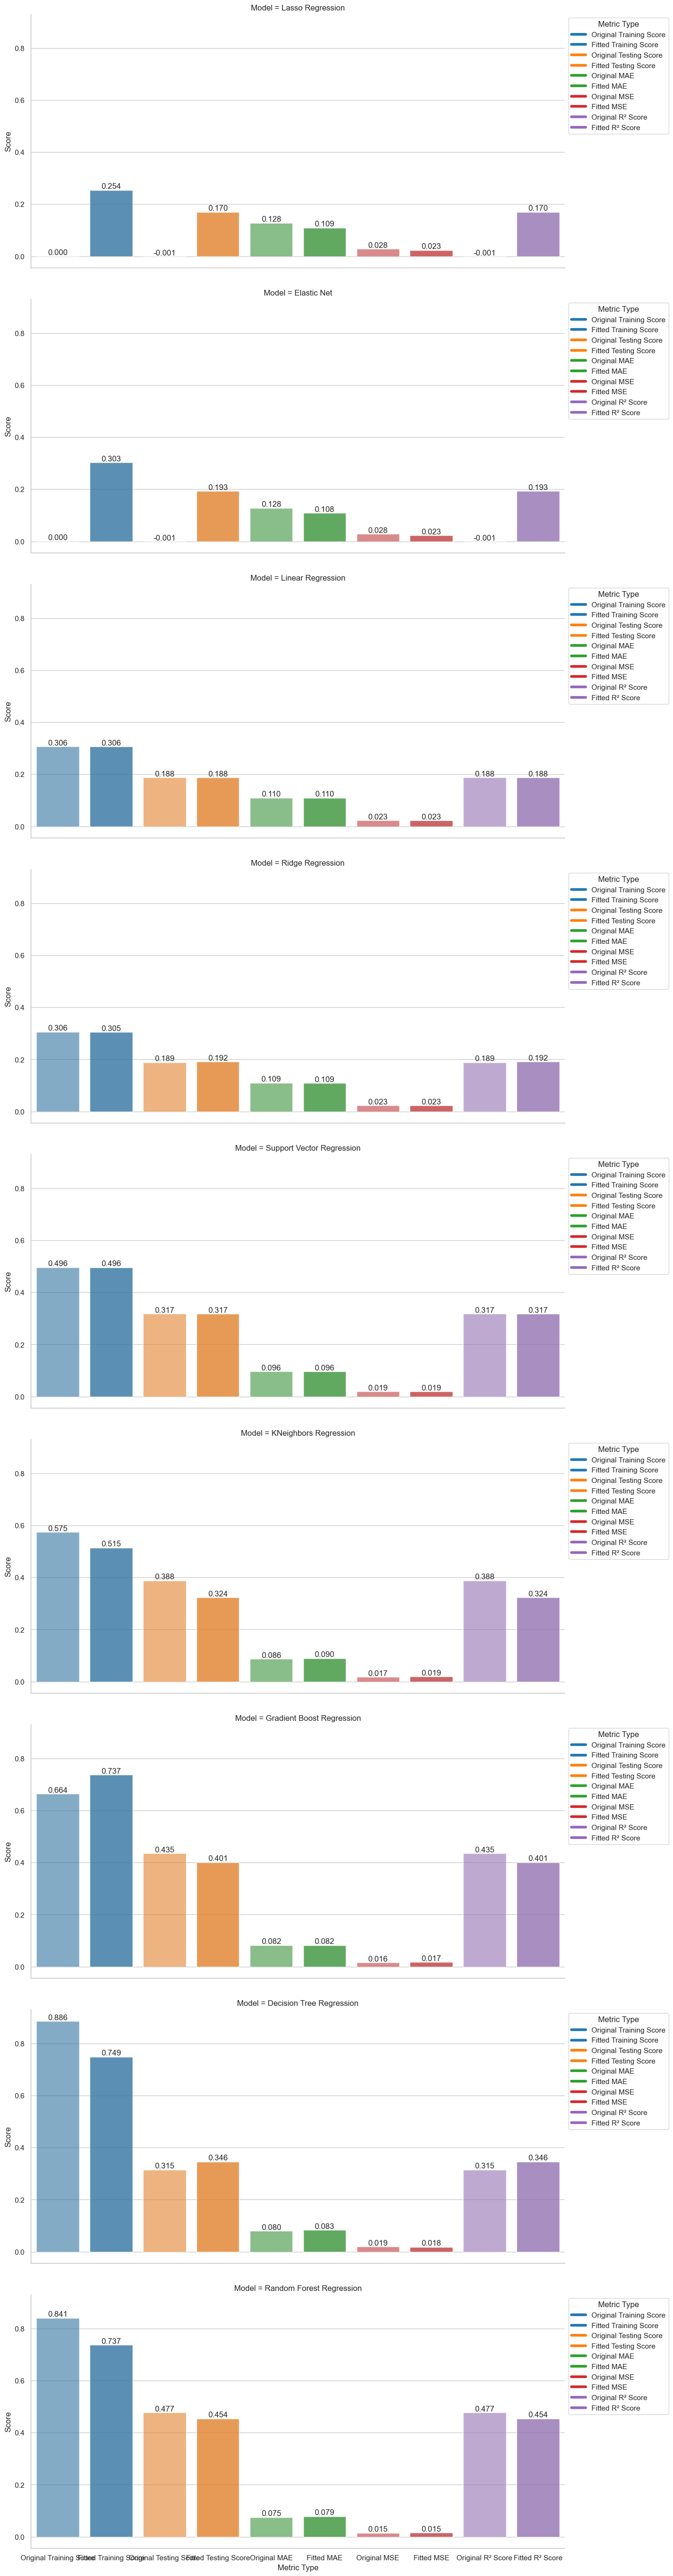

In [56]:
# Example metric color mapping
metric_color_map = {
    'Original Training Score': '#1f77b4',  # Blue
    'Fitted Training Score': '#1f77b4',    # Same base color
    'Original Testing Score': '#ff7f0e',   # Orange
    'Fitted Testing Score': '#ff7f0e',     # Same base color
    'Original MAE': '#2ca02c',             # Green
    'Fitted MAE': '#2ca02c',               # Same base color
    'Original MSE': '#d62728',             # Red
    'Fitted MSE': '#d62728',               # Same base color
    'Original R² Score': '#9467bd',        # Purple
    'Fitted R² Score': '#9467bd',          # Same base color
}

# Create a FacetGrid to plot separate graphs for each model
g = sns.FacetGrid(filtered_data, col='Model', hue='Metric Type', height=6, aspect=2, col_wrap=1)

# Map a bar plot to each facet
for ax in g.axes.flat:
    for metric_type in metrics_to_plot:
        # Filter data for the current metric type
        model_name = ax.get_title().split(' = ')[1]  # Get the model name from the title
        model_data = filtered_data[(filtered_data['Model'] == model_name) & 
                                   (filtered_data['Metric Type'] == metric_type)]  # Filter for the specific model
        
        # Plot only if there is data for the current metric type and model
        if not model_data.empty:
            shade = 0.6 if 'Original' in metric_type else 0.8  # Slightly darker for fitted metrics
            color = metric_color_map.get(metric_type, 'gray')  # Get the color from the mapping
            sns.barplot(x='Metric Type', y='Score', data=model_data, 
                        alpha=shade, color=color, ax=ax)

# Add metric names on top of each bar
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom')

# Create a custom legend for each ax
for ax in g.axes.flat:
    handles = [plt.Line2D([0], [0], color=metric_color_map[metric], lw=4) for metric in metric_color_map.keys()]
    labels = list(metric_color_map.keys())
    ax.legend(handles=handles, labels=labels, title='Metric Type', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

## This Section Focuses on Just the Days of the Dataset and Adds the Mean for the NaN values, Drops the NaN, and Fills NaN with Zeros

In [65]:
# Load the data
data = pd.read_csv('garments_worker_productivity.csv')

# Assuming 'days' is a list of unique days you want to filter by
days = data['day'].unique()  # Replace this with your actual days list if needed

# Create a list of DataFrames, one for each day
df_days = [data[data['day'] == day] for day in days]

# To view the head of each DataFrame in the list, you can loop through them
for i, df in enumerate(df_days):
    print(f"Data for day {days[i]}:")
    print(df.head())  # Display the first few rows of each DataFrame
    print("\n")  # Add a newline for better readability

Data for day Thursday:
       date   quarter  department       day  team  targeted_productivity  \
0  1/1/2015  Quarter1      sweing  Thursday     8                   0.80   
1  1/1/2015  Quarter1  finishing   Thursday     1                   0.75   
2  1/1/2015  Quarter1      sweing  Thursday    11                   0.80   
3  1/1/2015  Quarter1      sweing  Thursday    12                   0.80   
4  1/1/2015  Quarter1      sweing  Thursday     6                   0.80   

     smv     wip  over_time  incentive  idle_time  idle_men  \
0  26.16  1108.0       7080         98        0.0         0   
1   3.94     NaN        960          0        0.0         0   
2  11.41   968.0       3660         50        0.0         0   
3  11.41   968.0       3660         50        0.0         0   
4  25.90  1170.0       1920         50        0.0         0   

   no_of_style_change  no_of_workers  actual_productivity  
0                   0           59.0             0.940725  
1                   0

In [66]:
day_df_copy = data.copy()

# Convert date strings to datetime format if applicable
date_columns = day_df_copy.select_dtypes(include=['object']).columns.tolist()
for col in date_columns:
    try:
        day_df_copy[col] = pd.to_datetime(day_df_copy[col])
    except (ValueError, TypeError):
        # If conversion fails, you can choose to drop the column or handle it differently
        print(f"Column '{col}' could not be converted to datetime.")

# Calculate the mean of the 'wip' column
mean_wip = day_df_copy['wip'].mean()

# Fill missing values in 'wip' with the mean
day_df_copy['wip'].fillna(value=mean_wip, inplace=True)

Column 'quarter' could not be converted to datetime.
Column 'department' could not be converted to datetime.
Column 'day' could not be converted to datetime.


In [67]:
# Please enter the Target name that you wish to use
target = 'actual_productivity'

# Step 2: Define your features (X) and target (y)
X = day_df_copy.drop(target, axis=1)  # Replace 'target_column' with your actual target column name
y = day_df_copy[target].values.reshape(-1,1)  # Your target variable

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [68]:
# Drop the target column from the copy
day_df_copy = day_df_copy.drop(columns=[target]) 

# Determine categorical and numerical features
categorical_features = day_df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = day_df_copy.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create the preprocessor for just the numerical columns
num_preprocessor = create_numerical_preprocessor(numerical_features)

# Create the preprocessor for just the categorical columns
cat_preprocessor = create_categorical_preprocessor(categorical_features)

# Print the identified features (optional)
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: ['quarter', 'department', 'day']
Numerical Features: ['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']


In [69]:
# Ensure that X_train and X_test only contain numerical features
# Remove any columns that are not numeric
X_train = X_train.select_dtypes(include=['int64', 'float64'])
X_test = X_test.select_dtypes(include=['int64', 'float64'])

# Check for any non-numeric columns before fitting
print("X_train columns:", X_train.columns)
print("X_test columns:", X_test.columns)

X_train columns: Index(['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers'],
      dtype='object')
X_test columns: Index(['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers'],
      dtype='object')


In [70]:
# Fit and transform the training data
X_train_processed = num_preprocessor.fit_transform(X_train)

# Transform the testing data
X_test_processed = num_preprocessor.transform(X_test)

In [71]:
# Dictionary of regression models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest Regression': RandomForestRegressor(),
    'Support Vector Regression': SVR(),
    'Elastic Net': ElasticNet(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Gradient Boost Regression': GradientBoostingRegressor(),
    'KNeighbors Regression': KNeighborsRegressor()
}

# Create pipelines using the preprocessor and models
pipelines = create_pipelines(num_preprocessor, models)

metrics_df = evaluate_models(pipelines, X_train_processed, y_train, X_test_processed, y_test)

print("----------------------------------------------------------------------")
print("The dataset is modified with the NaN values being filled with the mean value of the column affected")

X_train shape: (897, 10)
y_train shape: (897, 1)
X_test shape: (300, 10)
y_test shape: (300, 1)
                           Training Score  Testing Score  Mean Absolute Error  Mean Squared Error  R² Score
Lasso Regression                 0.000000      -0.000685             0.128256            0.028178 -0.000685
Elastic Net                      0.000000      -0.000685             0.128256            0.028178 -0.000685
Linear Regression                0.306007       0.188046             0.109552            0.022864  0.188046
Ridge Regression                 0.305997       0.188579             0.109464            0.022849  0.188579
Support Vector Regression        0.496357       0.317175             0.095912            0.019228  0.317175
KNeighbors Regression            0.574632       0.388269             0.086326            0.017226  0.388269
Gradient Boost Regression        0.663522       0.436264             0.081732            0.015874  0.436264
Decision Tree Regression         0.88589

In [72]:
# Load the data
data = pd.read_csv('garments_worker_productivity.csv')

# Assuming 'days' is a list of unique days you want to filter by
days = data['day'].unique()  # Replace this with your actual days list if needed

day_df_copy = data.copy()
# Please enter the Target name that you wish to use
target = 'actual_productivity'

# Step 2: Define your features (X) and target (y)
X = day_df_copy.drop(target, axis=1)  # Replace 'target_column' with your actual target column name
y = day_df_copy[target].values.reshape(-1,1)  # Your target variable

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Dropping NaN Values That May Be Present in Dataset
data = data.dropna()

# Drop the target column from the copy
day_df_copy = day_df_copy.drop(columns=[target]) 

# Determine categorical and numerical features
categorical_features = day_df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = day_df_copy.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create the preprocessor for just the numerical columns
num_preprocessor = create_numerical_preprocessor(numerical_features)

# Create the preprocessor for just the categorical columns
cat_preprocessor = create_categorical_preprocessor(categorical_features)

# Print the identified features (optional)
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

# Ensure that X_train and X_test only contain numerical features
# Remove any columns that are not numeric
X_train = X_train.select_dtypes(include=['int64', 'float64'])
X_test = X_test.select_dtypes(include=['int64', 'float64'])

# Check for any non-numeric columns before fitting
print("X_train columns:", X_train.columns)
print("X_test columns:", X_test.columns)

# Fit and transform the training data
X_train_processed = num_preprocessor.fit_transform(X_train)

# Transform the testing data
X_test_processed = num_preprocessor.transform(X_test)

# Dictionary of regression models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest Regression': RandomForestRegressor(),
    'Support Vector Regression': SVR(),
    'Elastic Net': ElasticNet(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Gradient Boost Regression': GradientBoostingRegressor(),
    'KNeighbors Regression': KNeighborsRegressor()
}

# Create pipelines using the preprocessor and models
pipelines = create_pipelines(num_preprocessor, models)

metrics_df = evaluate_models(pipelines, X_train_processed, y_train, X_test_processed, y_test)

print("----------------------------------------------------------------------")
print("The dataset is modified with the NaN values being dropped")

Categorical Features: ['date', 'quarter', 'department', 'day']
Numerical Features: ['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']
X_train columns: Index(['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers'],
      dtype='object')
X_test columns: Index(['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers'],
      dtype='object')
X_train shape: (897, 10)
y_train shape: (897, 1)
X_test shape: (300, 10)
y_test shape: (300, 1)
                           Training Score  Testing Score  Mean Absolute Error  Mean Squared Error  R² Score
Lasso Regression                 0.000000      -0.000685             0.128256            0.028178 -0.000685
Elastic Net                      0.000000      -0.000685             0.128256         

In [76]:
# Load the data
data = pd.read_csv('garments_worker_productivity.csv')

# Assuming 'days' is a list of unique days you want to filter by
days = data['day'].unique()  # Replace this with your actual days list if needed

day_df_copy = data.copy()
# Please enter the Target name that you wish to use
target = 'actual_productivity'

# Step 2: Define your features (X) and target (y)
X = day_df_copy.drop(target, axis=1)  # Replace 'target_column' with your actual target column name
y = day_df_copy[target].values.reshape(-1,1)  # Your target variable

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Filling NaN Values That May Be Present in Dataset with 0
data = data.fillna(0)

# Drop the target column from the copy
day_df_copy = day_df_copy.drop(columns=[target]) 

# Determine categorical and numerical features
categorical_features = day_df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = day_df_copy.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create the preprocessor for just the numerical columns
num_preprocessor = create_numerical_preprocessor(numerical_features)

# Create the preprocessor for just the categorical columns
cat_preprocessor = create_categorical_preprocessor(categorical_features)

# Print the identified features (optional)
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

# Ensure that X_train and X_test only contain numerical features
# Remove any columns that are not numeric
X_train = X_train.select_dtypes(include=['int64', 'float64'])
X_test = X_test.select_dtypes(include=['int64', 'float64'])

# Check for any non-numeric columns before fitting
print("X_train columns:", X_train.columns)
print("X_test columns:", X_test.columns)

# Fit and transform the training data
X_train_processed = num_preprocessor.fit_transform(X_train)

# Transform the testing data
X_test_processed = num_preprocessor.transform(X_test)

# Dictionary of regression models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest Regression': RandomForestRegressor(),
    'Support Vector Regression': SVR(),
    'Elastic Net': ElasticNet(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Gradient Boost Regression': GradientBoostingRegressor(),
    'KNeighbors Regression': KNeighborsRegressor()
}

# Create pipelines using the preprocessor and models
pipelines = create_pipelines(num_preprocessor, models)

metrics_df = evaluate_models(pipelines, X_train_processed, y_train, X_test_processed, y_test)

print("----------------------------------------------------------------------")
print("The dataset is modified with the NaN values filled with 0")

Categorical Features: ['date', 'quarter', 'department', 'day']
Numerical Features: ['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']
X_train columns: Index(['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers'],
      dtype='object')
X_test columns: Index(['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers'],
      dtype='object')
X_train shape: (897, 10)
y_train shape: (897, 1)
X_test shape: (300, 10)
y_test shape: (300, 1)
                           Training Score  Testing Score  Mean Absolute Error  Mean Squared Error  R² Score
Lasso Regression                 0.000000      -0.000685             0.128256            0.028178 -0.000685
Elastic Net                      0.000000      -0.000685             0.128256         

## This Section Revisits the Original Data and Tries Dropping NaN and Replacing with Zeros

In [74]:
#Load your dataset
data = pd.read_csv('garments_worker_productivity.csv')
data.head()

data = data.dropna()

data_copy = data.copy()
# Please enter the Target name that you wish to use
target = 'actual_productivity'

# Step 2: Define your features (X) and target (y)
X = data_copy.drop(target, axis=1)  # Replace 'target_column' with your actual target column name
y = data_copy[target].values.reshape(-1,1)  # Your target variable

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Drop the target column from the copy
day_df_copy = data_copy.drop(columns=[target]) 

# Determine categorical and numerical features
categorical_features = data_copy.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = data_copy.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create the preprocessor for just the numerical columns
num_preprocessor = create_numerical_preprocessor(numerical_features)

# Create the preprocessor for just the categorical columns
cat_preprocessor = create_categorical_preprocessor(categorical_features)

# Print the identified features (optional)
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

# Ensure that X_train and X_test only contain numerical features
# Remove any columns that are not numeric
X_train = X_train.select_dtypes(include=['int64', 'float64'])
X_test = X_test.select_dtypes(include=['int64', 'float64'])

# Check for any non-numeric columns before fitting
print("X_train columns:", X_train.columns)
print("X_test columns:", X_test.columns)

# Fit and transform the training data
X_train_processed = num_preprocessor.fit_transform(X_train)

# Transform the testing data
X_test_processed = num_preprocessor.transform(X_test)

# Dictionary of regression models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest Regression': RandomForestRegressor(),
    'Support Vector Regression': SVR(),
    'Elastic Net': ElasticNet(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Gradient Boost Regression': GradientBoostingRegressor(),
    'KNeighbors Regression': KNeighborsRegressor()
}

# Create pipelines using the preprocessor and models
pipelines = create_pipelines(num_preprocessor, models)

metrics_df = evaluate_models(pipelines, X_train_processed, y_train, X_test_processed, y_test)

print("----------------------------------------------------------------------")
print("The dataset is modified with the NaN values being dropped")

Categorical Features: ['date', 'quarter', 'department', 'day']
Numerical Features: ['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'actual_productivity']
X_train columns: Index(['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers'],
      dtype='object')
X_test columns: Index(['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers'],
      dtype='object')
X_train shape: (518, 10)
y_train shape: (518, 1)
X_test shape: (173, 10)
y_test shape: (173, 1)
                           Training Score  Testing Score  Mean Absolute Error  Mean Squared Error  R² Score
Elastic Net                      0.000000      -0.000209             0.113491            0.023086 -0.000209
Lasso Regression                 0.224467       0.233420       

In [75]:
#Load your dataset
data = pd.read_csv('garments_worker_productivity.csv')
data.head()

data = data.fillna(0)

data_copy = data.copy()
# Please enter the Target name that you wish to use
target = 'actual_productivity'

# Step 2: Define your features (X) and target (y)
X = data_copy.drop(target, axis=1)  # Replace 'target_column' with your actual target column name
y = data_copy[target].values.reshape(-1,1)  # Your target variable

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Drop the target column from the copy
day_df_copy = data_copy.drop(columns=[target]) 

# Determine categorical and numerical features
categorical_features = data_copy.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = data_copy.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create the preprocessor for just the numerical columns
num_preprocessor = create_numerical_preprocessor(numerical_features)

# Create the preprocessor for just the categorical columns
cat_preprocessor = create_categorical_preprocessor(categorical_features)

# Print the identified features (optional)
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

# Ensure that X_train and X_test only contain numerical features
# Remove any columns that are not numeric
X_train = X_train.select_dtypes(include=['int64', 'float64'])
X_test = X_test.select_dtypes(include=['int64', 'float64'])

# Check for any non-numeric columns before fitting
print("X_train columns:", X_train.columns)
print("X_test columns:", X_test.columns)

# Fit and transform the training data
X_train_processed = num_preprocessor.fit_transform(X_train)

# Transform the testing data
X_test_processed = num_preprocessor.transform(X_test)

# Dictionary of regression models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest Regression': RandomForestRegressor(),
    'Support Vector Regression': SVR(),
    'Elastic Net': ElasticNet(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Gradient Boost Regression': GradientBoostingRegressor(),
    'KNeighbors Regression': KNeighborsRegressor()
}

# Create pipelines using the preprocessor and models
pipelines = create_pipelines(num_preprocessor, models)

metrics_df = evaluate_models(pipelines, X_train_processed, y_train, X_test_processed, y_test)

print("----------------------------------------------------------------------")
print("The dataset is modified with the NaN values being filled with 0")

Categorical Features: ['date', 'quarter', 'department', 'day']
Numerical Features: ['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'actual_productivity']
X_train columns: Index(['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers'],
      dtype='object')
X_test columns: Index(['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers'],
      dtype='object')
X_train shape: (897, 10)
y_train shape: (897, 1)
X_test shape: (300, 10)
y_test shape: (300, 1)
                           Training Score  Testing Score  Mean Absolute Error  Mean Squared Error  R² Score
Lasso Regression                 0.000000      -0.000685             0.128256            0.028178 -0.000685
Elastic Net                      0.000000      -0.000685       